In [24]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass
from functools import partial

jax.devices()

jax.enable_checks = True

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [2]:
# list requirements
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.3.25
equinox==0.9.2
optax==0.1.4
chex==0.1.5
tensorflow==2.10.1


In [3]:
NUM_EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096


In [4]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [5]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])

            
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3,4,5,6,7,8))
def trainingSet(n, m, T1 = 1.0, T2 = 2.0, K = 1.10, volMult = 1.5, anti=True, seed=2, bktVol=0.2):

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        print(X.shape, inc1.shape)
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if False:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)

            # # differentials
            # Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
            # Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            Y = pay
            
            # # differentials
            # Z =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        return Y

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    return X, Y.reshape(-1,1), Z, ddYddX, a

# test set: returns an array of independent, uniformly random spots 
# with corresponding baskets, ground true prices, deltas and vegas
def testSet(n, a, T1 = 1.0, T2 = 2.0, K = 1.10, bktVol = 0.2, lower=0.5, upper=1.50, num=4096, seed=42):
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(num, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, a).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ a.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas    

In [6]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])


@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = True


           
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2):
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult
    anti = params.anti

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    bktVol = bktVol

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

    def func(X, inc1):
        S2 = X + inc1
        bkt2 = jnp.dot(S2, a)
        pay = jnp.maximum(0, bkt2 - K)

        # two antithetic paths
        # if anti:
        if True:
            
            S2a = X - inc1
            bkt2a = jnp.dot(S2a, a)
            paya = jnp.maximum(0, bkt2a - K)
            
            Y = 0.5 * (pay + paya)
        # standard
        else:
            Y = pay

        return Y

    y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
    # basis = jnp.eye(y.size, dtype=y.dtype)
    # jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    jac = vjpfun(jnp.ones(y.size))[0]

    h = 1e-4
    fd_ph = func(S1 + h, inc1)
    fd_mh = func(S1 - h, inc1)
    fd = (fd_ph - fd_mh) / (2 * h)

    # def cfd(f, h):

    #     def cfd_fn(x, *args):
    #         return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

    #     return cfd_fn

    # cfd_fn = cfd(func, h)
    # cfd_fd = cfd_fn(S1, inc1)

    fdd = (fd_ph - 2 * y + fd_mh) / (h * h)

    # use finite differences to check:
    # h = 1e-4
    jac_fdd_ph = vjpfun(jnp.ones(y.size) + h)[0]
    jac_fdd_mh = vjpfun(jnp.ones(y.size) - h)[0]

    jac_fdd = (jac_fdd_ph - jac_fdd_mh) / (2 * h)

    print("jac is: ")
    print(jac.shape)

    print("y is: ")
    print(y.shape)
    print(y)
    if 0: 
        y, vjpfun = jax.vjp(func, S1, inc1)  # Compute the values and obtain a VJP function
        basis = jnp.eye(y.size, dtype=y.dtype)
        jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
        # return y, jac, vjpfun

        Y = y
        Z = jac

        # Y, Z = jax.vmap(value_and_jacrev(func, argnums=0))(S1, inc1)

    Y, Z = jax.vmap(jax.value_and_grad(func, argnums=0))(S1, inc1)
    print("Y is: ")
    print(Y.shape)
    print(Y)
    jax.debug.print("{val}", val=(Y - y).sum())
    print("Z is: ")
    print(Z.shape)
    jax.debug.print("Diff is: {val}", val=(Z - jac).sum())
    jax.debug.print("Example values: {val1}, {val2}", val1=Z[2,0], val2=jac[2,0])

    ddYddX = jax.vmap(jax.hessian(func, argnums=0))(S1, inc1)
    
    X = S1
    # return X, Y.reshape(-1,1), Z, ddYddX, a
    return X, y.reshape(-1,1), jac, ddYddX, a, fd, fdd, jac_fdd

def testSet(params: BachelierParams, weights, n_samples=4096, seed=42):
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return spots, baskets, prices, deltas, vegas   



In [8]:
bachelier_params = BachelierParams(n_dim=1)
X, Y, Z, W, weights, fd, fdd, jac_fd = trainingSet(10 * N_TRAINING_SAMPLES, bachelier_params, seed=42)

def info(X, Y, Z, W, fd, jac_fd):
    print(X.shape)
    print(Y.shape)
    print(Z.shape)
    print(W.shape)
    print("FD")
    print(fd.shape)
    print(fd)
    print("JAC_FD")
    print(jac_fd)

# info(X, Y, Z, W, fd, jac_fd)

spots, baskets, prices, deltas, vegas = testSet(bachelier_params, weights, n_samples=10 * N_TEST_SAMPLES)
# print(spots.shape)

0.0
Diff is: 0.0
Example values: 0.5, 0.5


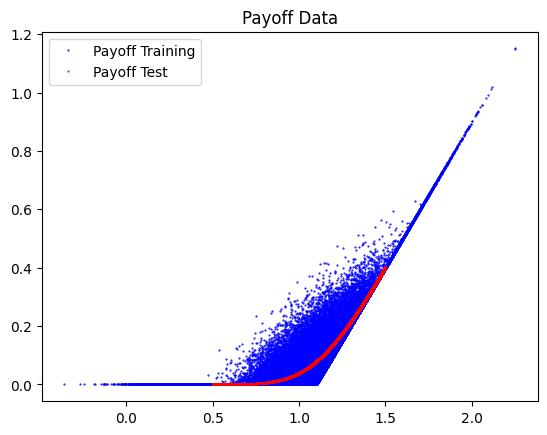

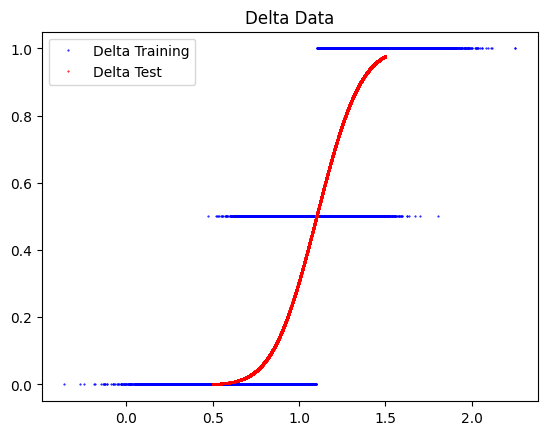

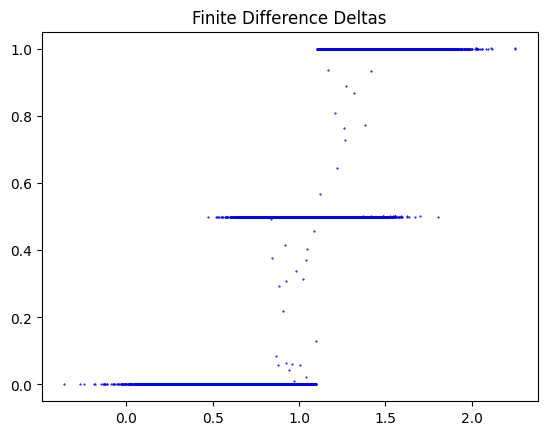

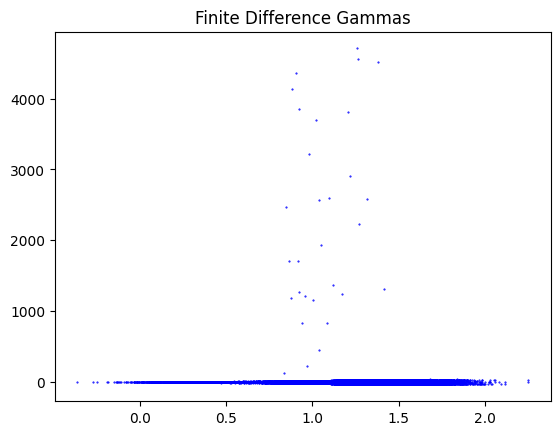

In [9]:
def plot_payoff_data(x_train, y_train, x_test, y_test):
    plt.title("Payoff Data")
    plt.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    plt.plot(x_test, y_test, 'r.', label='Payoff Test', markersize=1)
    plt.legend()
    plt.show()

def plot_delta_data(x_train, x_test, dydx_train, dydx_test):
    plt.title("Delta Data")
    plt.plot(x_train, dydx_train, 'b.', label='Delta Training', markersize=1)
    plt.plot(x_test, dydx_test, 'r.', label='Delta Test', markersize=1)
    plt.legend()
    plt.show()

plot_payoff_data(X[:,0], Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(X[:,0], baskets[:, 0], Z[:,0], deltas[:,0])

plt.title("Finite Difference Deltas")
plt.plot(X[:,0], fd, 'b.', label='FD', markersize=1)
plt.show()

plt.title("Finite Difference Gammas")
plt.plot(X[:,0], fdd, 'b.', label='FD', markersize=1)
plt.show()

In [10]:
bachelier_params = BachelierParams(n_dim=7)
X, Y, Z, W, weights, fd, fdd, jac_fd= trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
spots, baskets, prices, deltas, vegas = testSet(bachelier_params, weights, n_samples=N_TEST_SAMPLES)

jac is: 
(8192, 7)
y is: 
(8192,)
Traced<ShapedArray(float32[8192])>with<DynamicJaxprTrace(level=0/1)>
Y is: 
(8192,)
Traced<ShapedArray(float32[8192])>with<DynamicJaxprTrace(level=0/1)>
Z is: 
(8192, 7)
0.0
Example values: 0.0, 0.0
Diff is: 0.0


In [11]:

print(X.shape)
print(baskets.shape)
print(deltas.shape)
print(Y.shape)

(8192, 7)
(4096, 1)
(4096, 7)
(8192, 1)


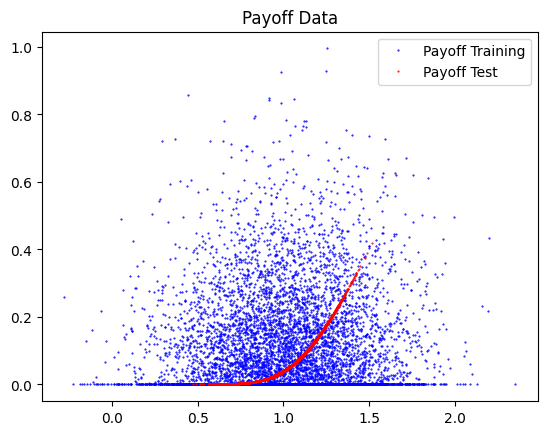

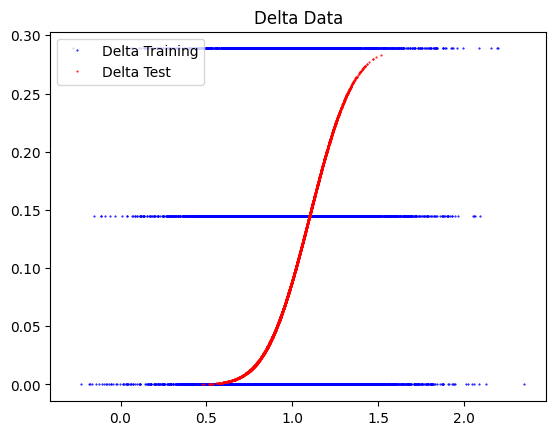

In [12]:
vis_dim = 0
plot_payoff_data(X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

In [13]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [14]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [15]:
key, subkey = jax.random.split(key)
model = eqx.nn.MLP(key=subkey, in_size=1, out_size=1, width_size=20, depth=3, activation=jax.nn.elu)

In [16]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model


key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

20 1
20 20
20 20
1 20


In [17]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    predictions = vmap(model)(x)
    targets = y
    chex.assert_type([predictions], float)
    if targets is not None:
        # Avoid broadcasting logic for "-" operator.
        chex.assert_equal_shape((predictions, targets))
    errors = predictions - targets if targets is not None else predictions
    result = jnp.mean(errors ** 2)
    chex.assert_type([result], float)
    return result

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = baskets
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE) 

tf.as_numpy(train_dataset)

AttributeError: module 'tensorflow' has no attribute 'as_numpy'

In [20]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          optim: optax.GradientTransformation,
          steps: int
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(NUM_EPOCHS):
        for step, (batch_x, batch_y, batch_dydx) in enumerate(train_dataset):
            model, opt_state, loss_value = train_step(model, opt_state, batch_x, batch_y)

            if (step % 100 == 0) or (step == steps-1):
                test_loss = loss_fn(model, x_test, y_test)
                print(f"epoch: {epoch}, step: {step}, train_loss: {loss_value}, test_loss: {test_loss}")

    return model

In [21]:
optim = optax.adam(learning_rate)
model = train(model, x_train, y_train, optim, steps=1000)

ValueError: Non-hashable static arguments are not supported. An error occurred during a call to 'train_step' while trying to hash an object of type <class 'tuple'>, (((<function train.<locals>.train_step at 0x000002428D6C4B80>,), PyTreeDef(*)), ((<CompiledFunction of <function elu at 0x00000242C425DAF0>>, <function _identity at 0x00000242DBF31B80>, <tf.Tensor: shape=(256, 7), dtype=float32, numpy=
array([[-0.52112836, -0.59560454,  0.27351815, ..., -1.0418152 ,
         0.6165643 , -1.0477283 ],
       [-0.6475198 ,  0.2643899 ,  0.5559103 , ...,  0.37067026,
         2.1046906 ,  0.7890162 ],
       [-0.11084361, -0.23075528, -0.48838446, ...,  0.85613185,
        -1.8534594 , -0.24612169],
       ...,
       [ 0.29516453,  0.43822548,  0.54202694, ..., -2.258336  ,
         0.42254665,  0.70271176],
       [-0.9511665 , -0.78959465,  0.11015268, ...,  0.5136385 ,
        -1.1790023 ,  3.049301  ],
       [-0.08664854, -0.71805304,  0.13296106, ..., -2.5644882 ,
         1.131069  , -0.59354335]], dtype=float32)>, <tf.Tensor: shape=(256, 1), dtype=float32, numpy=
array([[-0.70557815],
       [ 0.6964551 ],
       [-0.70557815],
       [-0.70557815],
       [ 0.72729224],
       [ 0.7844932 ],
       [-0.70557815],
       [ 1.5822889 ],
       [-0.70557815],
       [-0.70557815],
       [ 1.3045877 ],
       [ 0.90535617],
       [ 0.25512257],
       [-0.04629406],
       [ 0.544789  ],
       [-0.25212455],
       [ 0.6715941 ],
       [-0.70557815],
       [-0.70557815],
       [ 0.21715914],
       [ 1.0908045 ],
       [ 1.7369865 ],
       [-0.70557815],
       [ 0.46664187],
       [-0.70557815],
       [-0.70557815],
       [-0.6202012 ],
       [-0.70557815],
       [-0.70557815],
       [-0.6739659 ],
       [-0.70557815],
       [-0.70557815],
       [ 0.14061497],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 2.0085232 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.58336467],
       [ 0.4206955 ],
       [ 0.36654475],
       [-0.70557815],
       [ 2.468856  ],
       [ 0.44864622],
       [ 1.2970393 ],
       [-0.70557815],
       [ 1.3350646 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.19568008],
       [-0.70557815],
       [-0.70557815],
       [ 0.43999544],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.4090633 ],
       [ 2.1740677 ],
       [ 0.8168153 ],
       [-0.70557815],
       [-0.70557815],
       [-0.4110371 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.10732549],
       [-0.70557815],
       [-0.54722273],
       [ 0.42359892],
       [ 2.2800825 ],
       [ 1.9417028 ],
       [-0.70557815],
       [-0.4710481 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.51509494],
       [-0.70557815],
       [ 0.31626388],
       [ 0.7490017 ],
       [-0.70557815],
       [-0.55202097],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.31346825],
       [-0.3889237 ],
       [ 1.2884258 ],
       [-0.70557815],
       [-0.3746062 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.17328414],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.3498703 ],
       [-0.70557815],
       [ 1.1693033 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.8212958 ],
       [-0.70557815],
       [ 1.4345474 ],
       [ 0.07941595],
       [ 2.315756  ],
       [-0.70557815],
       [-0.14361128],
       [-0.5493573 ],
       [ 0.73415935],
       [-0.45785236],
       [ 1.6808684 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.67491543],
       [ 1.651674  ],
       [ 0.46388572],
       [-0.2933656 ],
       [-0.70557815],
       [ 0.12284333],
       [-0.70557815],
       [ 0.35687697],
       [ 0.8791413 ],
       [ 1.360389  ],
       [ 0.08705947],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.1029982 ],
       [-0.70557815],
       [-0.70557815],
       [-0.12094846],
       [-0.70557815],
       [-0.35726434],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.5341399 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.5062269 ],
       [ 0.79870766],
       [ 0.30694655],
       [-0.70557815],
       [ 0.1769627 ],
       [-0.28452218],
       [ 0.09304147],
       [-0.70557815],
       [ 0.30483234],
       [-0.5480806 ],
       [-0.70557815],
       [-0.70557815],
       [ 0.81127375],
       [ 0.29796994],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.74149734],
       [-0.70557815],
       [-0.04977236],
       [ 0.7625402 ],
       [ 3.344365  ],
       [ 0.7021177 ],
       [ 0.69107056],
       [-0.3052579 ],
       [ 3.3765898 ],
       [ 1.8940815 ],
       [-0.70557815],
       [-0.36977738],
       [-0.09594868],
       [ 0.18190819],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.22676753],
       [ 1.9159627 ],
       [-0.70557815],
       [ 1.491358  ],
       [-0.70557815],
       [-0.70557815],
       [-0.03456128],
       [-0.70557815],
       [-0.30662283],
       [ 1.6101292 ],
       [-0.70557815],
       [-0.47915366],
       [-0.27430454],
       [ 0.4721436 ],
       [ 0.2387273 ],
       [-0.70557815],
       [ 0.17891484],
       [-0.70557815],
       [ 0.7164356 ],
       [-0.70557815],
       [-0.62389034],
       [ 0.4608317 ],
       [ 0.18215342],
       [-0.21778327],
       [-0.70557815],
       [-0.70557815],
       [ 1.2479064 ],
       [ 0.99441636],
       [ 1.900189  ],
       [ 2.0334215 ],
       [-0.70557815],
       [ 1.4258338 ],
       [-0.70557815],
       [-0.18068793],
       [ 0.6763253 ],
       [ 0.49964455],
       [-0.70557815],
       [ 0.45615736],
       [-0.61182874],
       [-0.6233681 ],
       [-0.53129333],
       [ 4.9121375 ],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [-0.70557815],
       [ 0.33942947],
       [ 1.7736741 ],
       [ 0.9851241 ],
       [ 0.39597875],
       [-0.70557815],
       [ 0.3961913 ],
       [ 0.00539246],
       [-0.70557815],
       [-0.70557815],
       [-0.46722317],
       [ 0.36817273],
       [ 1.8857437 ],
       [-0.13468939],
       [-0.5290985 ],
       [ 0.25482726],
       [-0.40336215],
       [ 1.7261392 ],
       [ 0.5677505 ],
       [-0.08104564],
       [-0.62019867],
       [-0.70557815]], dtype=float32)>), PyTreeDef(((CustomNode(MLP[(('layers', 'activation', 'final_activation'), ('in_size', 'out_size', 'width_size', 'depth'), (1, 1, 20, 3))], [[CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (1, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 1, True))], [None, None])], *, *]), (CustomNode(namedtuple[ScaleByAdamState], [None, CustomNode(MLP[(('layers', 'activation', 'final_activation'), ('in_size', 'out_size', 'width_size', 'depth'), (1, 1, 20, 3))], [[CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (1, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 1, True))], [None, None])], None, None]), CustomNode(MLP[(('layers', 'activation', 'final_activation'), ('in_size', 'out_size', 'width_size', 'depth'), (1, 1, 20, 3))], [[CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (1, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 20, True))], [None, None]), CustomNode(Linear[(('weight', 'bias'), ('in_features', 'out_features', 'use_bias'), (20, 1, True))], [None, None])], None, None])]), CustomNode(namedtuple[EmptyState], [])), *, *), {}))), <function is_array at 0x00000242DBEAB8B0>). The error was:
TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

At:
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py(901): __hash__
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\site-packages\equinox\jit.py(78): _fun_wrapper
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\site-packages\equinox\jit.py(82): __call__
  C:\Users\neilk\AppData\Local\Temp\ipykernel_9572\1420409112.py(23): train
  C:\Users\neilk\AppData\Local\Temp\ipykernel_9572\298073066.py(2): <module>
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(3460): run_code
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(3400): run_ast_nodes
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(3221): run_cell_async
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py(129): _pseudo_sync_runner
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(3016): _run_cell
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(2961): run_cell
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py(540): run_cell
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py(422): do_execute
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(729): execute_request
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(409): dispatch_shell
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(502): process_one
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(513): dispatch_queue
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py(80): _run
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py(1905): _run_once
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py(601): run_forever
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py(215): start
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py(725): start
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py(1043): launch_instance
  C:\Users\neilk\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py(17): <module>
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\runpy.py(87): _run_code
  c:\Users\neilk\AppData\Local\Programs\Python\Python39\lib\runpy.py(197): _run_module_as_main

